# Descriptive figures

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# paths
data_dir = os.path.abspath('../data')
fig_dir = os.path.abspath('../figures')

In [3]:
# plt.style.use('seaborn-v0_8-dark')
# plt.rcParams["font.family"] = 'times new roman'

# plot formatting
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# minor axis
plt.rcParams['xtick.minor.bottom'] = True

# grid lines
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams['grid.linewidth'] = 2

dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.set_option('future.no_silent_downcasting', True)

# orders of magnitude
M = 1_000_000
B = 1_000_000_000
T = 1_000_000_000_000

# Canada's trade partners

In [4]:
# trade by trading partners
src = os.path.join(data_dir, 'CA-part.csv')
tp = pd.read_csv(src, index_col=[0, 1, 2])

In [5]:
# European countries

# European Union (EU)
# The EU is a single-market trade union, and sets trade policies for all member countries
EU = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
    'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
    ]

# European Economic Area (EEA)
# Free internal trade with EEA
# (though Canada has no trade with Liechtenstein)
EEA = ['Iceland', 'Liechtenstein', 'Norway'] + EU

# EAA plus UK and Switzerland (EEA+)
# EEA countries plus Switzerland: https://www.gov.uk/eu-eea
EEA_plus = EEA + ['United Kingdom', 'Switzerland']

In [6]:
# trade series with countries across time
cous = tp.pivot_table(index=['year', 'cou'], values=tp.columns, aggfunc='sum')
cous = cous.reset_index()
cous = cous.sort_values(['year', 'tradebalance'])

cous['cou'] = cous['cou'].str.split(' (', regex=False).str[0]

# make imports negative
cous['imports'] = -cous['imports']

# label EU and EEA countries
cous['eu'] = cous['cou'].isin(EU)
cous['eea'] = cous['cou'].isin(EEA)
cous['eea+'] = cous['cou'].isin(EEA_plus)


# aggregate EU (a single-market partner) and EEA+ countries
areas = [('eu', 'European Union'), ('eea+', 'EEA+ (West Europe)')]

for abbrev, name in areas:
    
    area = cous.pivot_table(index=['year', abbrev], values=tp.columns, aggfunc='sum')
    area = area.reset_index()
    area = area[area[abbrev]]
    area = area.rename(columns={abbrev : 'cou'})
    area['cou'] = name
    area[abbrev] = True

    cous = pd.concat([cous, area])
    

# remove individual EU countries after aggregating
cond = cous['eu'] & (cous['cou']!='European Union')
cous = cous[~cond].reset_index(drop=True)

# cous = cous.drop(columns=['eu', 'eea', 'eea+'])

# calculate shares
sdfs = []
cols = tp.columns
share_cols = [(c+'share').replace('ss', 's') for c in cols]

for year, sdf in cous.groupby('year'):
    
    cond = sdf['cou'] == 'Total All Countries'
    sdf[share_cols] = sdf[cols] / sdf.loc[cond, cols].iloc[0]

    sdfs.append(sdf)

cous = pd.concat(sdfs)

Saved: /home/qcx201/Projects/CAtrade/figures/03-import_partners.png


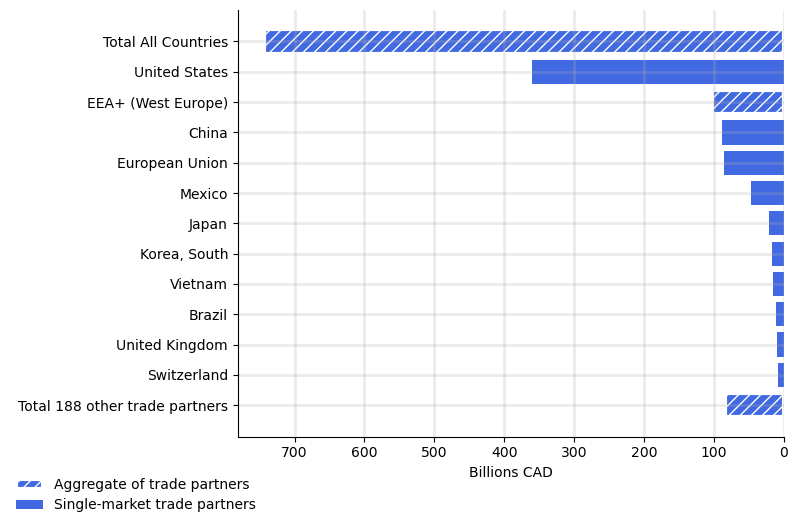

,cou,imports
0,Total All Countries,-744.148423
1,United States,-359.702858
2,EEA+ (West Europe),-103.101211
3,China,-88.397183
4,European Union,-84.856715
5,Mexico,-47.07908
6,Japan,-21.118049
7,"Korea, South",-16.77144
8,Vietnam,-14.630059
9,Brazil,-10.19631


Saved: /home/qcx201/Projects/CAtrade/figures/03-export_partners.png


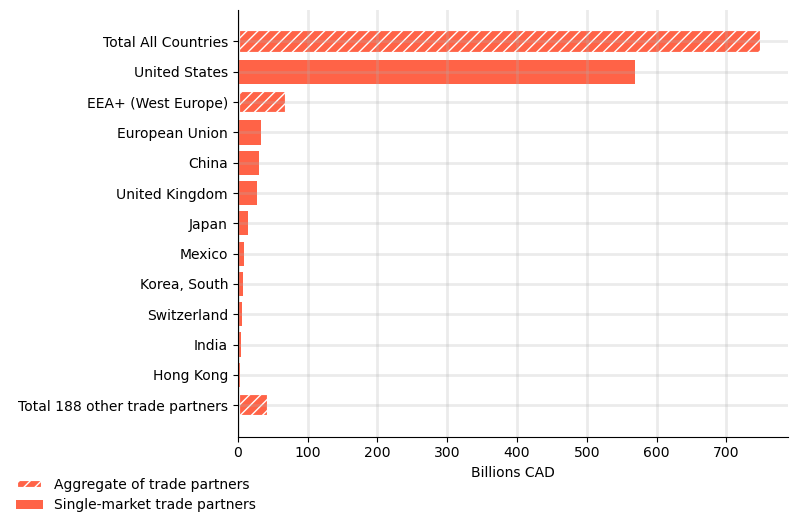

,cou,exports
0,Total All Countries,750.702179
1,United States,569.252073
2,EEA+ (West Europe),70.248974
3,European Union,33.579627
4,China,29.808881
5,United Kingdom,28.142693
6,Japan,14.819743
7,Mexico,8.462675
8,"Korea, South",7.567014
9,Switzerland,6.217219


In [7]:
# number of top
top = 10
year = 2024

# trade in latest year
cond = cous['year'] == year
df = cous[cond]

data_dict = {}

# # top net import partners
# title, col = f'Canada\'s top {top} net import partners ({year})', 'tradebalance'
# data = df.sort_values(col)
# cond = data['cou'].str.contains('Total') | data['cou'].str.contains('Import')
# data = data[~cond] # remove totals and reimports for net trade balance rank
# data_dict[title] = {'data' : data, 'col' : col}

# # top net export partners
# title, col = f'Canada\'s top {top} net export partners ({year})', 'tradebalance'
# data = df.sort_values(col, ascending=False)
# cond = data['cou'].str.contains('Total') | data['cou'].str.contains('Import')
# data = data[~cond] # remove totals and reimports for net trade balance rank
# data_dict[title] = {'data' : data, 'col' : col}

# top gross import partners
title, col = f'Canada\'s Top Import Partners ({year})', 'imports'
data = df.sort_values(col)
data_dict[title] = {'data' : data, 'col' : col}

# top gross export partners
title, col = f'Canada\'s Top Export Partners ({year})', 'exports'
data = df.sort_values(col, ascending=False)
data_dict[title] = {'data' : data, 'col' : col}


for title, params in data_dict.items():
    
    data = params['data']
    col = params['col']
    
    # add 2 for all countries and EEA+
    nhead = top if 'net' in title.lower() else top + 2
    sdf = data.head(nhead)

    others = data.iloc[nhead:]
    nothers = len(others)
    others = others.sum(axis=0).to_frame().T
    others[['year', 'cou']] = 2024, f'Total {nothers} other trade partners'
    sdf = pd.concat([sdf, others]).reset_index(drop=True)

    x, y = sdf['cou'], sdf[col] / B

    fig, ax = plt.subplots(figsize=(8, 5))

    # formatting
    kwargs = {
        'color' : 'tomato' if 'export' in title.lower() else 'royalblue',
        'fill' : False if 'net' in title.lower() else True,
        'linewidth' : 3
    }
    kwargs['edgecolor'] = kwargs['color'] if 'net' in title.lower() else None

    # plot bar
    bars = ax.barh(x, y, **kwargs)

    # ax.set_title(title) # remove title for article
    ax.set_xlabel('Billions CAD')
    
    # reverse negative sign for imports
    if 'import' in title.lower():
        xlim = ax.get_xlim()
        xticks = ax.get_xticks()
        ax.set_xticks(xticks, -xticks.astype(int))
        ax.set_xlim(xlim)

    
    # # add source and title
    # ax.set_title(title)
    # fig.text(1, 0, 'Data source: ISED Canada   ', ha='right', va='bottom')

    # add hatch to bar for total all countries export/import
    if 'net' not in title.lower():
        for i in (0, 2, -1):
            bars[i].set_hatch('///')
            bars[i].set_edgecolor('white')

        fig.legend((bars[0], bars[1]), ('Aggregate of trade partners', 'Single-market trade partners'),
                   bbox_to_anchor=(0, 0), loc='center left', frameon=False)

    # invert order of countries
    fig.gca().invert_yaxis()
    
    # save figures
    n = 4 if 'net' in title.lower() else 3
    tag = '_'.join(title.split()[-n:-1])
    file = f'03-{tag}.png'.lower()

    fig.tight_layout()

    dst = os.path.join(fig_dir, file)
    plt.savefig(dst, bbox_inches='tight')

    print('Saved:', dst)
    
    plt.show()
    display(pd.merge(x, y, left_index=True, right_index=True).reset_index(drop=True))

Saved: /home/qcx201/Projects/CAtrade/figures/03-importshare.png


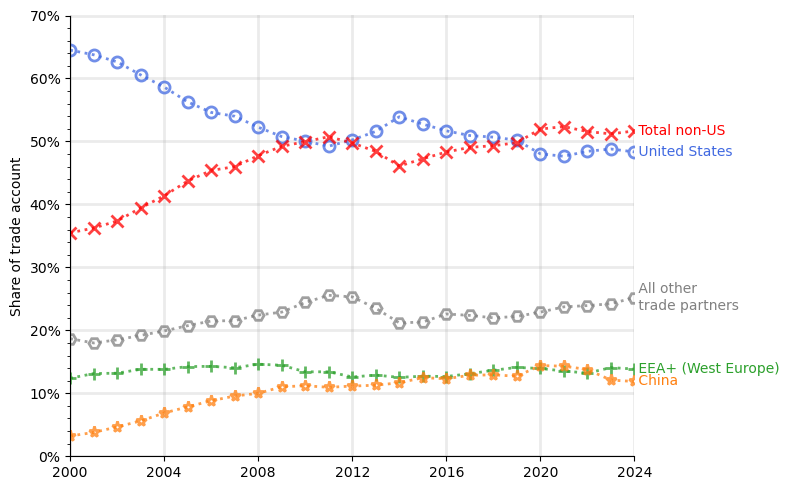

Saved: /home/qcx201/Projects/CAtrade/figures/03-exportshare.png


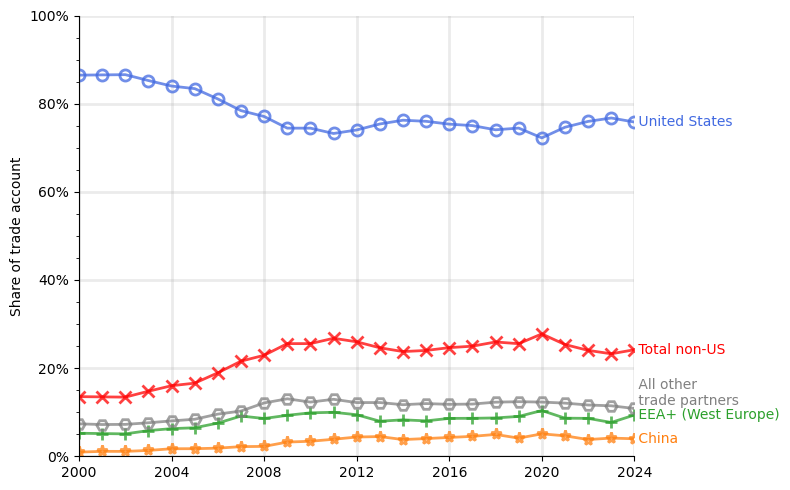

In [41]:
partners = ['United States', 'EEA+ (West Europe)', 'China']

cols = ['importshare', 'exportshare']

# aggregate other trade partners
cond1 = ~(cous['cou'].isin(partners)) # already listed partners
cond2 = ~(cous['eea+'].fillna(True).astype(bool)) # EEA+ countries
cond3 = ~cous['cou'].str.contains('total', case=False) # aggregates
cond4 = ~cous['cou'].str.contains('import', case=False) # re-imports

cond = cond1 & cond2 & cond3 & cond4

sdf = cous[cond]

others = sdf.groupby('year').sum()
others = others.reset_index()

label = f'All other\n trade partners'
others['cou'] = label
partners.append(label)

# add non-US import/export share
cond = cous['cou'] == 'United States'
non_us = 1 - (cous.loc[cond, ['year']+cols].set_index('year'))
non_us = non_us.reset_index()

label = 'Total non-US'
non_us['cou'] = label
partners.append(label)

# create final dataset
cond = cous['cou'].isin(partners)
data = pd.concat([cous[cond], others, non_us])

data = data.sort_values(['year', 'cou'])

# account
linestyles = [':', '-', '-.']

# partners
markers = ['o', '+', '*', 'H', 'x']
colors = ['royalblue', dcolors[2], dcolors[1], 'gray', 'red']

for i, col in enumerate(cols):
    
    fig, ax = plt.subplots(figsize=(8, 5))

    for j, cou in enumerate(partners):
        
        cond = data['cou'] == cou
        x, y = data.loc[cond, 'year'], data.loc[cond, col]

        ax.plot(x, y, lw=2, ls=linestyles[i], alpha=0.75,
                marker=markers[j], fillstyle='none',
                markersize=8, markeredgewidth=2,
                label=cou, color=colors[j])
        
        ax.set_xlim(2000, 2024)
        ax.set_xticks(range(2000, 2025, 4))
        
        xend, yend = x.dropna().iloc[-1], y.dropna().iloc[-1]

        va = 'bottom' if (('other' in cou) and ('export' in col)) else 'center'
        ax.text(xend, yend, f' {cou}', va=va, ha='left', color=colors[j])

    _, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax)

    ax.set_ylabel('Share of trade account')
    ticks = ax.get_yticks()
    ax.set_yticks(ticks, [f'{t:.0%}' for t in ticks])
    ax.yaxis.minorticks_on()

    fig.tight_layout()
    # fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3, frameon=False)
    
    dst = os.path.join(fig_dir, f'03-{col}.png')
    
    fig.savefig(dst, bbox_inches='tight')
    print('Saved:', dst)
    
    plt.show()

## What do we trade?

In [9]:
# Canada's trade by sector/product

# sector HS2 codes
src = os.path.join(data_dir, 'HS2_codes.csv')
codes = pd.read_csv(src)
split = codes['code'].str.split(' - ')
codes['hs2'] = split.str[0].astype(int)
# codes['prod'] = split.str[1]
# codes['sector'] = codes['sec'].str.split(' - ').str[-1]

# products
prods = tp.pivot_table(index=['year', 'hs2'], values=tp.columns, aggfunc='sum')
prods = prods.reset_index()

prods = pd.merge(prods, codes, on='hs2', how='left')
prods

,year,hs2,exports,imports,tradebalance,sec,code
0,2000,1,3.482722e+09,7.724365e+08,4.065429e+09,I - LIVE ANIMALS AND ANIMAL PRODUCTS,01 - Live animals
1,2000,2,7.303783e+09,2.278516e+09,7.537900e+09,I - LIVE ANIMALS AND ANIMAL PRODUCTS,02 - Meat and edible meat offal
2,2000,3,7.125652e+09,3.256301e+09,5.804027e+09,I - LIVE ANIMALS AND ANIMAL PRODUCTS,"03 - Fish and crustacean, mollusc and other aq..."
3,2000,4,7.235371e+08,8.486863e+08,-1.877238e+08,I - LIVE ANIMALS AND ANIMAL PRODUCTS,04 - Dairy prod; birds' eggs; natural honey; e...
4,2000,5,3.523901e+08,2.106411e+08,2.126236e+08,I - LIVE ANIMALS AND ANIMAL PRODUCTS,"05 - Products of animal origin, not elsewhere ..."
...,...,...,...,...,...,...,...
2395,2024,93,9.375977e+08,1.376407e+09,-6.582135e+08,XIX - ARMS AND AMMUNITION,93 - Arms and ammunition; parts and accessorie...
2396,2024,94,1.672249e+10,2.579256e+10,-1.360503e+10,XX - MISCELLANEOUS MANUFACTURED PRODUCTS,"94 - Furniture; bedding, mattress, matt suppor..."
2397,2024,95,2.439340e+09,1.382941e+10,-1.708497e+10,XX - MISCELLANEOUS MANUFACTURED PRODUCTS,"95 - Toys, games & sports requisites; parts & ..."
2398,2024,96,2.715503e+09,4.821628e+09,-3.159188e+09,XX - MISCELLANEOUS MANUFACTURED PRODUCTS,96 - Miscellaneous manufactured articles


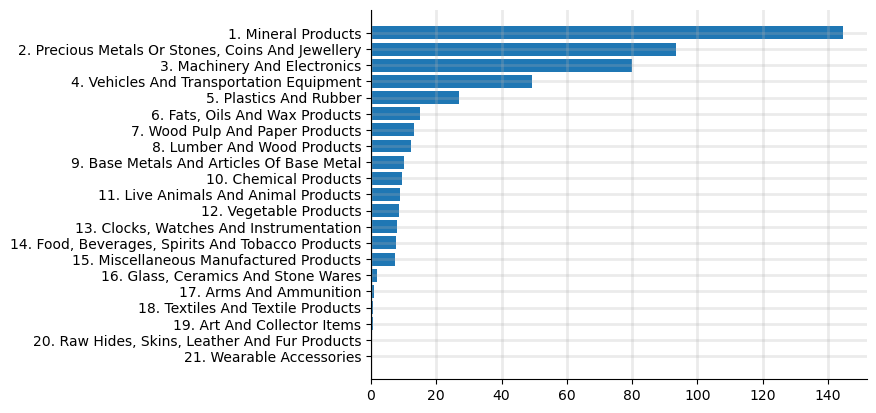

In [10]:
# stacked bar graph for US/non-US

# sectors
secs = prods.pivot_table(index=['year', 'sec'], values=tp.columns)
secs = secs.reset_index()

for year, sdf in secs.groupby('year'):
    continue

sdf = sdf.sort_values('exports', ascending=False)

sdf['rank'] = range(1, len(sdf)+1)

split = sdf['sec'].str.split(' - ')
sdf['sector'] = sdf['rank'].astype(str) + '. ' + split.str[-1].str.title()

fig, ax = plt.subplots()

x, y = sdf['sector'], sdf['exports'] / B
ax.barh(x, y)

fig.gca().invert_yaxis()

plt.show()

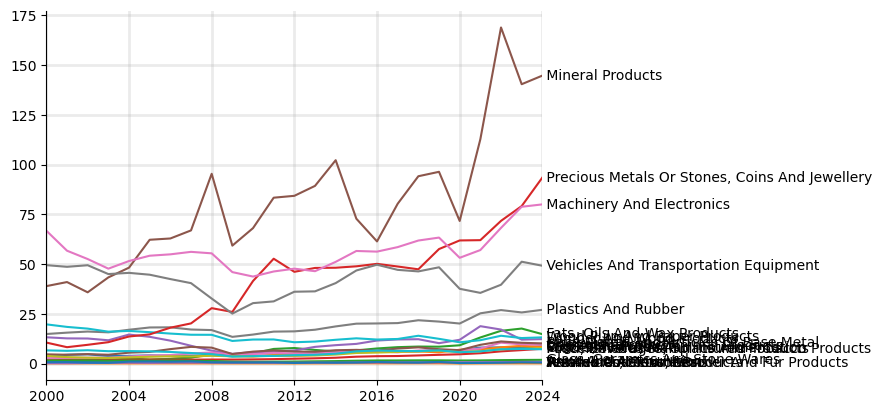

In [11]:
fig, ax = plt.subplots()

for sec, sdf in secs.groupby('sec'):

    x, y = sdf['year'], sdf['exports'] / B

    ax.plot(x, y)

    ax.set_xlim(2000, 2024)
    ax.set_xticks(range(2000, 2025, 4))

    text = ' ' + (sec.split(' - ')[-1].title())
    ax.text(x.iloc[-1], y.iloc[-1], text, va='center', ha='left')

plt.show()

## Trade by Province

In [12]:
# Breakdown trade by sector with top trader